In [32]:
from pathlib import Path
import numpy as np
import pandas as pd
import typing as tp
import yaml
import random
import os
import sys
import soundfile as sf
import librosa
import librosa.display
import cv2
import matplotlib.pyplot as plt
import time
import pickle
import glob
from tqdm import tqdm
import IPython.display
from scipy import signal

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
# import resnest.torch as resnest_torch

pd.options.display.max_rows = 500
pd.options.display.max_columns = 500

In [2]:
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
set_seed(777)

In [156]:
WIN_LEN = 2048
HOP_LEN = 512

In [3]:
DATA_DIR = Path("/home/knikaido/work/BirdCLEF2021/data/")
MAIN_DATA_DIR = DATA_DIR / 'birdclef-2021'
DENOISE_DIR = DATA_DIR / 'birdclef-2021-denoise/train_short_audio'
OUTPUT_DIR = MAIN_DATA_DIR / 'birdclef-2021-melspectrogram'

In [4]:
######################
# Data #
######################
train_datadir = MAIN_DATA_DIR / 'train_short_audio'
train_csv = MAIN_DATA_DIR / 'train_metadata.csv'
train_soundscape = MAIN_DATA_DIR / 'train_soundscape_labels.csv'

output_train_datadir = OUTPUT_DIR / 'train_short_audio'

In [6]:
wav_path_list = sorted(glob.glob(str(train_datadir) + '/*/*.ogg')) 
len(wav_path_list)

62874

In [7]:
denoise_wav_path_list = sorted(glob.glob(str(DENOISE_DIR) + '/*/*.ogg')) 
len(denoise_wav_path_list)

62873

In [8]:
train = pd.read_csv(MAIN_DATA_DIR / 'train_metadata.csv')
train

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,date,filename,license,rating,time,url
0,acafly,['amegfi'],"['begging call', 'call', 'juvenile']",35.3860,-84.1250,Empidonax virescens,Acadian Flycatcher,Mike Nelson,2012-08-12,XC109605.ogg,Creative Commons Attribution-NonCommercial-Sha...,2.5,09:30,https://www.xeno-canto.org/109605
1,acafly,[],['call'],9.1334,-79.6501,Empidonax virescens,Acadian Flycatcher,Allen T. Chartier,2000-12-26,XC11209.ogg,Creative Commons Attribution-NonCommercial-Sha...,3.0,?,https://www.xeno-canto.org/11209
2,acafly,[],['call'],5.7813,-75.7452,Empidonax virescens,Acadian Flycatcher,Sergio Chaparro-Herrera,2012-01-10,XC127032.ogg,Creative Commons Attribution-NonCommercial-Sha...,3.0,15:20,https://www.xeno-canto.org/127032
3,acafly,['whwbec1'],['call'],4.6717,-75.6283,Empidonax virescens,Acadian Flycatcher,Oscar Humberto Marin-Gomez,2009-06-19,XC129974.ogg,Creative Commons Attribution-NonCommercial-Sha...,3.5,07:50,https://www.xeno-canto.org/129974
4,acafly,['whwbec1'],['call'],4.6717,-75.6283,Empidonax virescens,Acadian Flycatcher,Oscar Humberto Marin-Gomez,2009-06-19,XC129981.ogg,Creative Commons Attribution-NonCommercial-Sha...,3.5,07:50,https://www.xeno-canto.org/129981
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62869,yetvir,[],"['adult', 'male', 'song']",30.2150,-97.6505,Vireo flavifrons,Yellow-throated Vireo,Caleb Helsel,2020-07-10,XC591680.ogg,Creative Commons Attribution-NonCommercial-Sha...,1.0,08:30,https://www.xeno-canto.org/591680
62870,yetvir,[],"['life stage uncertain', 'sex uncertain', 'song']",42.3005,-72.5877,Vireo flavifrons,Yellow-throated Vireo,Christopher McPherson,2019-05-31,XC600085.ogg,Creative Commons Attribution-NonCommercial-Sha...,5.0,09:30,https://www.xeno-canto.org/600085
62871,yetvir,"['amered', 'eawpew', 'norcar', 'reevir1']","['adult', 'male', 'song']",42.3005,-72.5877,Vireo flavifrons,Yellow-throated Vireo,Christopher McPherson,2020-06-02,XC602701.ogg,Creative Commons Attribution-NonCommercial-Sha...,4.5,08:30,https://www.xeno-canto.org/602701
62872,yetvir,[],['uncertain'],32.2357,-99.8811,Vireo flavifrons,Yellow-throated Vireo,Brad Banner,2019-04-27,XC614733.ogg,Creative Commons Attribution-NonCommercial-Sha...,4.0,17:30,https://www.xeno-canto.org/614733


/usr/local/lib/python3.6/dist-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/usr/local/lib/python3.6/dist-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


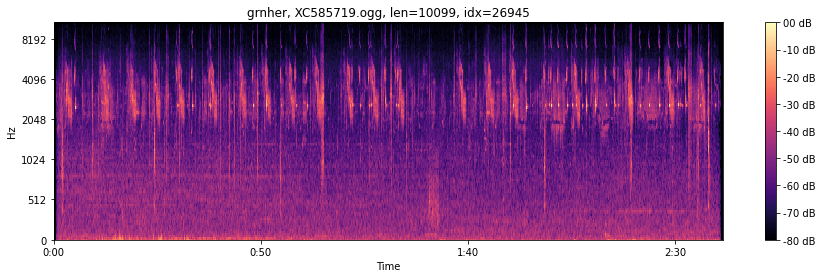

In [501]:
count = 0
while count < 1:
    idx = np.random.randint(len(train))
    raw = train.iloc[idx]

    wav_name = raw["filename"]
    ebird_code = raw["primary_label"]

    y, sr = sf.read(train_datadir / ebird_code / wav_name)

    melspec = librosa.feature.melspectrogram(y, sr=sr, n_fft=WIN_LEN, hop_length=HOP_LEN, n_mels=128,
                fmin=40, fmax=16000)
    melspec = librosa.power_to_db(np.abs(melspec), ref=np.max).astype(np.float32)

    plt.figure(figsize=(15,4))
    librosa.display.specshow(melspec, y_axis='mel', x_axis='time', sr=sr)
    plt.title(f'{ebird_code}, {wav_name}, len={melspec.shape[1]}, idx={idx}')
    plt.colorbar(format='%02.0f dB')
    
    count += 1
    

In [502]:
# idx = 15931
# raw = train.iloc[idx]
# wav_name = raw["filename"]
# ebird_code = raw["primary_label"]
IPython.display.Audio(train_datadir / ebird_code / wav_name)

In [503]:
mfcc_tmp = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=12, n_fft=WIN_LEN, hop_length=HOP_LEN)

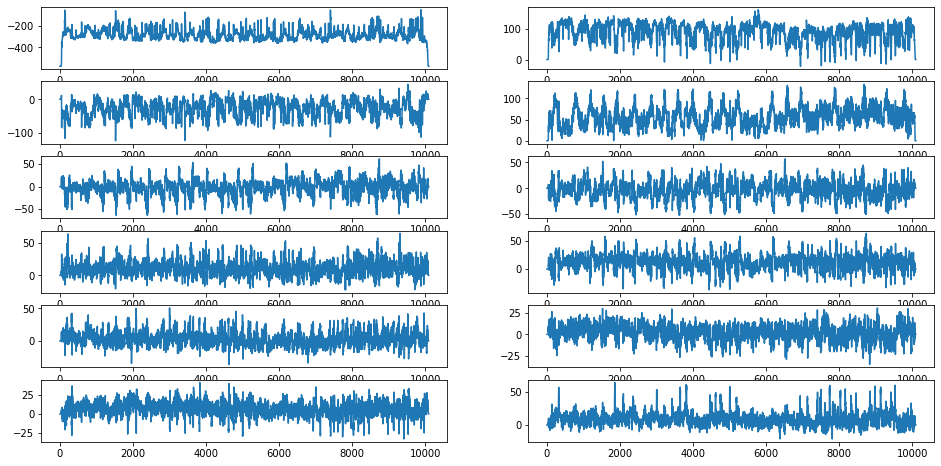

In [504]:
tate = int(mfcc_tmp.shape[0] / 2)

fig, ax = plt.subplots(tate, 2, figsize=(16, 8))

for i, mfcc_ in enumerate(mfcc_tmp):
    ax[int(i/2)][int(i%2)].plot(mfcc_)

# anom_name = ['norm', '2.5', '2.0', '1.5', '1.0']
# for i in range(0, 5):
#     ax[i].set_title(anom_name[i], fontsize=13)
#     ax[i].set_aspect(aspect='auto')
#     ax[i].axes.yaxis.set_visible(False)

74

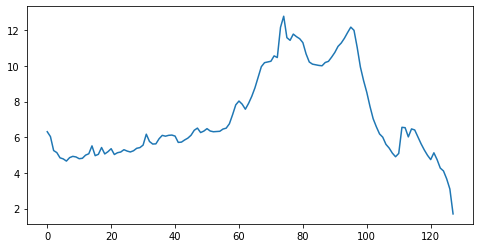

In [505]:
plt.figure(figsize=(8, 4))
mel_sum_by_time = np.std(melspec, axis=1)

plt.plot(mel_sum_by_time)
np.argmax(mel_sum_by_time)

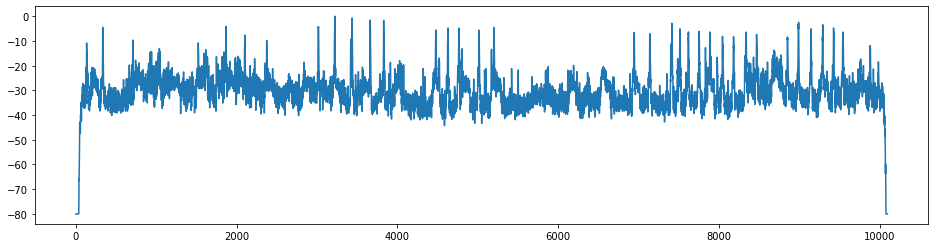

In [506]:
plt.figure(figsize=(16, 4))
mel_sum_by_freq = np.max(melspec, axis=0)
# mel_sum_by_freq = mfcc_tmp[8]

# mel_sum_by_freq = mfcc_tmp[2]
plt.plot(mel_sum_by_freq)

In [513]:
peakind = signal.find_peaks_cwt(mel_sum_by_freq, np.arange(1,10), min_snr=5)
# peakind = signal.find_peaks(mel_sum_by_freq, distance=30)[0]

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [514]:
# peakind = peakind[0]

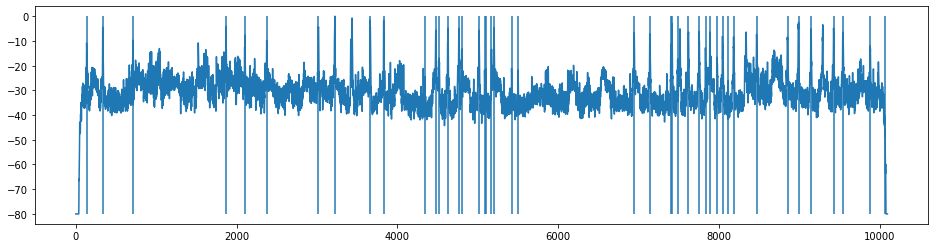

In [515]:
plt.figure(figsize=(16, 4))
# mel_sum_by_freq = np.sum(melspec, axis=0)
plt.vlines(peakind, ymin=np.min(mel_sum_by_freq), ymax=np.max(mel_sum_by_freq))
plt.plot(mel_sum_by_freq)

In [516]:
hop_time = HOP_LEN * (1 / sr)
win_time = WIN_LEN * (1 / sr)

In [517]:
peakind_time = np.array(peakind) * hop_time + (win_time / 2)

/usr/local/lib/python3.6/dist-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/usr/local/lib/python3.6/dist-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


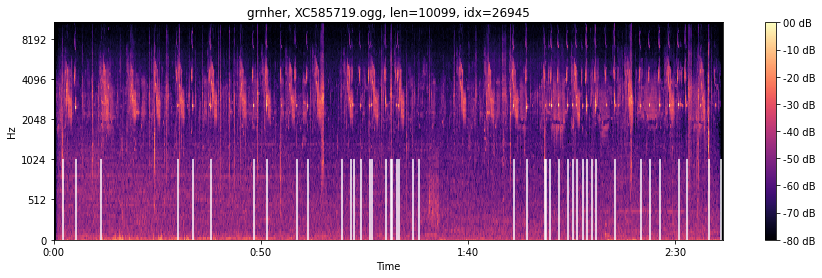

In [518]:
plt.figure(figsize=(15,4))
librosa.display.specshow(melspec, y_axis='mel', x_axis='time', sr=sr)
plt.vlines(peakind_time, ymin=0, ymax=1024, color='white')
plt.title(f'{ebird_code}, {wav_name}, len={melspec.shape[1]}, idx={idx}')
plt.colorbar(format='%02.0f dB')